In [45]:
import os
import shutil
import tarfile
import io
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [46]:
data_path = "data"
data_archive = "cifar-10-python.tar.gz"
shape = (32, 32, 3)
rotations = 3
partition_qnt = 10

seed = 12345

Clean previous data splits:

In [47]:
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file == data_archive:
            continue
        path = os.path.join(root, file)
        os.remove(path)
        print("Removed: {}".format(path))
    for dir in dirs:
        path = os.path.join(root, dir)
        shutil.rmtree(path)
        print("Removed: {}".format(path))

Removed: data/test.pkl


Extract the data batches from the tar-archive into the train and test arrays:

In [48]:
dataset_tar = tarfile.open(os.path.join(data_path, data_archive), "r:gz")

content = {
    "train": [],
    "test": []
}

members = [member for member in dataset_tar.getmembers() if member.isfile()]
members = sorted(members, key=lambda x: x.name)
for member in members:
    if "data_batch_" in member.name:
        print(member.name)
        content['train'].append(dataset_tar.extractfile(member).read())
    if "test_batch" in member.name:
        print(member.name)
        content['test'].append(dataset_tar.extractfile(member).read())

dataset_tar.close()

cifar-10-batches-py/data_batch_1
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/test_batch


Define some functions:

In [49]:
def parse(image_data):
    image = np.reshape(image_data, shape, order='F')
    return np.rot90(image, rotations)

Extract test images:

In [50]:
test_data = {}

for i in range(content['test'].__len__()):
    dict = pkl.load(io.BytesIO(content['test'][i]), encoding='bytes')
    for j in range(dict[b'labels'].__len__()):
        label = dict[b'labels'][j]
        if label not in test_data:
            test_data[label] = []
        image = parse(dict[b'data'][j])
        test_data[label].append(image)

print('\n'.join(['Class {}: {} images'.format(key, value.__len__()) for key, value in test_data.items()]))

Class 3: 1000 images
Class 8: 1000 images
Class 0: 1000 images
Class 6: 1000 images
Class 1: 1000 images
Class 9: 1000 images
Class 5: 1000 images
Class 7: 1000 images
Class 4: 1000 images
Class 2: 1000 images


Use a cat to verify extraction:

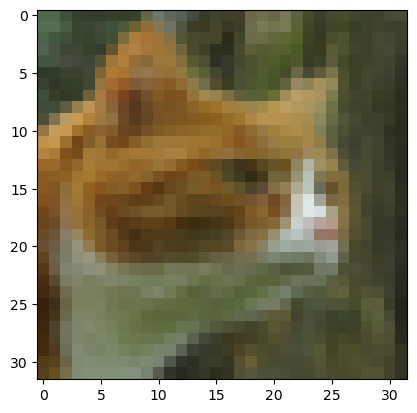

In [51]:
plt.imshow(test_data[3][9])

Save extracted data:

In [52]:
file_name = f"test.pkl"
with open(os.path.join(data_path, file_name), 'wb') as file:
    pkl.dump(test_data, file)

Reuse the cat to verify the saved extracted data:

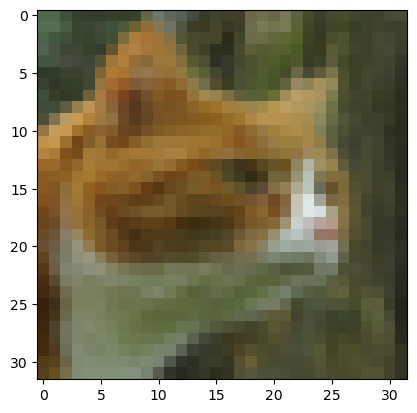

In [53]:
with open(os.path.join(data_path, file_name), 'rb') as file:
    loaded = pkl.load(file)
plt.imshow(loaded[3][9])

Transform the array of data batches into a nested dictionary {type: class: images}:

In [54]:
def parse(image_data):
    image = np.reshape(image_data, shape, order='F')
    return np.rot90(image, rotations)

data = {
    "train": {},
    "test": {}
}
for key, value in content.items():
    for i in range(value.__len__()):
        dict = pkl.load(io.BytesIO(value[i]), encoding='bytes')
        for j in range(dict[b'labels'].__len__()):
            label = dict[b'labels'][j]
            if label not in data[key]:
                data[key][label] = []
            image = parse(dict[b'data'][j])
            data[key][label].append(image)

print('\n'.join(["Type {}: {} classes\n{}".format(
    key, 
    len(value), 
    '\n'.join(["\tClass {}: {} images".format(k, len(v)) for k, v in value.items()])) 
    for key, value in data.items()])
)

Type train: 10 classes
	Class 6: 5000 images
	Class 9: 5000 images
	Class 4: 5000 images
	Class 1: 5000 images
	Class 2: 5000 images
	Class 7: 5000 images
	Class 8: 5000 images
	Class 3: 5000 images
	Class 5: 5000 images
	Class 0: 5000 images
Type test: 10 classes
	Class 3: 1000 images
	Class 8: 1000 images
	Class 0: 1000 images
	Class 6: 1000 images
	Class 1: 1000 images
	Class 9: 1000 images
	Class 5: 1000 images
	Class 7: 1000 images
	Class 4: 1000 images
	Class 2: 1000 images


Split the data into partitions:

In [55]:
partitions = [{"train": {}, "test": {}} for _ in range(partition_qnt)]

for type, classes in data.items():
    indices = np.arange(len(classes[0]))
    np.random.seed(seed)
    np.random.shuffle(indices)
    for i in range(partition_qnt):
        for label, images in classes.items():
            partitions[i][type][label] = [classes[label][idx] for idx in indices[i*len(images)//partition_qnt:(i+1)*len(images)//partition_qnt]]
        
print('\n'.join([f"Partition {part_idx}:\n" + '\n'.join([f"\tType {type}:\n\t\t" + '\n\t\t'.join([f"Class {label}: {len(images)} images" for label, images in classes.items()]) 
                                                         for type, classes in part.items()]) 
                 for part_idx, part in enumerate(partitions)]))

Partition 0:
	Type train:
		Class 6: 500 images
		Class 9: 500 images
		Class 4: 500 images
		Class 1: 500 images
		Class 2: 500 images
		Class 7: 500 images
		Class 8: 500 images
		Class 3: 500 images
		Class 5: 500 images
		Class 0: 500 images
	Type test:
		Class 3: 100 images
		Class 8: 100 images
		Class 0: 100 images
		Class 6: 100 images
		Class 1: 100 images
		Class 9: 100 images
		Class 5: 100 images
		Class 7: 100 images
		Class 4: 100 images
		Class 2: 100 images
Partition 1:
	Type train:
		Class 6: 500 images
		Class 9: 500 images
		Class 4: 500 images
		Class 1: 500 images
		Class 2: 500 images
		Class 7: 500 images
		Class 8: 500 images
		Class 3: 500 images
		Class 5: 500 images
		Class 0: 500 images
	Type test:
		Class 3: 100 images
		Class 8: 100 images
		Class 0: 100 images
		Class 6: 100 images
		Class 1: 100 images
		Class 9: 100 images
		Class 5: 100 images
		Class 7: 100 images
		Class 4: 100 images
		Class 2: 100 images
Partition 2:
	Type train:
		Class 6: 500 ima

Use a cat to verify [partition, type, class, item] structure:

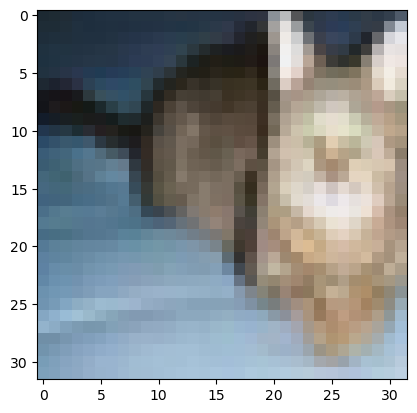

In [56]:
plt.imshow(partitions[0]['train'][3][65])

Save the partitioned data:

In [57]:
for partition_name, partition_data in enumerate(partitions):
    file_name = f"partition_{partition_name}.pkl"
    with open(os.path.join(data_path, file_name), 'wb') as file:
        pkl.dump(partition_data, file)

Reuse the cat to verify the saved data:

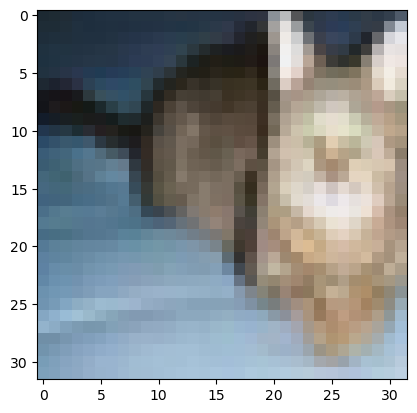

In [58]:
with open(os.path.join(data_path, 'partition_0.pkl'), 'rb') as file:
    loaded = pkl.load(file)
plt.imshow(loaded['train'][3][65])